# OPTIMISERS AND CALLBACKS

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import random
from random import choice
from string import ascii_uppercase
from time import sleep

from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array

import os
from os import listdir
from os.path import isfile, join
import re
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

### CLASSIFICATION

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator

In [3]:
model = Sequential()

In [4]:
#Adding Convolution layer
img_width, img_height = 64,64
model.add(Conv2D(32,(3,3),input_shape=(img_width,img_height,3),activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [5]:
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [6]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

In [7]:
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0

In [9]:
#Generating image data

train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale=1./255)

In [10]:
#Fitting image to the CNN
#Defining data directory
train_data_dir = 'D:/DATASCIENCE/TshirtShirt/training'
validation_data_dir = 'D:/DATASCIENCE/TshirtShirt/validation'

nb_train_samples =1397
nb_validation_samples = 40
epochs = 20
batch_size = 30

training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size=(64,64),
                                                batch_size = batch_size,
                                                class_mode = 'binary')


test_set = test_datagen.flow_from_directory(validation_data_dir,
                                           target_size=(64,64),
                                           batch_size=batch_size,
                                           class_mode='binary')

Found 1397 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


#### EARLY STOPPING

In [11]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor ='val_loss',
                  min_delta = 0,
                  patience=5,
                  verbose=1) #To keeps the best weight

#### REDUCE LR ON PLATEAU

In [12]:
from keras.callbacks import ReduceLROnPlateau

rlrop = ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=3,
                          verbose = 1,
                         min_delta=0)

#### CHECK POINT

In [13]:
from keras.callbacks import ModelCheckpoint

mcp = ModelCheckpoint('fr_4_optimiser.h5',
                     monitor='val_loss',
                     model='min',
                     save_best_only=True,
                     verbose=1)

#### CALLBACKS

In [14]:

callbacks = [es,rlrop,mcp]

In [15]:
#Training and Evaluating the model

def model_fit(optimiser,epochs):
    
    #Compiling the CNN
    model.compile(optimizer = optimiser,loss = 'binary_crossentropy',metrics = ['accuracy'])

    history = model.fit( 
        training_set, 
        steps_per_epoch=nb_train_samples // batch_size, 
        epochs=epochs, 
        validation_data=test_set, 
        callbacks=callbacks,
        validation_steps=nb_validation_samples // batch_size)
    
    results = model.evaluate(test_set, batch_size=batch_size)
    print("test loss, test acc:", results)
    
    # Loss Curves
    plt.figure(figsize=[5,5])
    plt.plot(history.history['loss'],'r',linewidth=1.0)
    plt.plot(history.history['val_loss'],'b',linewidth=1.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
    plt.xlabel('Epochs ',fontsize=12)
    plt.ylabel('Loss',fontsize=12)
    plt.title('Loss Curves',fontsize=12)
    
    # Accuracy Curves
    plt.figure(figsize=[5,5])
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
    plt.xlabel('Epochs ',fontsize=12)
    plt.ylabel('Accuracy',fontsize=12)
    plt.title('Accuracy Curves',fontsize=12)
    
    

    history4 = history
    accuracy = history4.history['accuracy']
    val_accuracy = history4.history['val_accuracy']
    loss = history4.history['loss']
    val_loss = history4.history['val_loss']
    epochs = range(len(accuracy))

    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    return model

#### FUNCTION TO PREDICT TEST DATA

In [16]:
class_labels = test_set.class_indices
class_labels = {v:k for k, v in class_labels.items()}
classes = list(class_labels.values())

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500, cv2.BORDER_CONSTANT, value=BLACK)
    cv2.putText(expanded_image, "predicted - "+pred,(20,60), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
    cv2.putText(expanded_image, "true - "+true_label,(20,120), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
    cv2.imshow(name, expanded_image)
    
def getRandomImage(path, img_width, img_height):
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path,x)),os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" +image_name
    return load_img(final_path,target_size = (img_width,img_height)), final_path, path_class

def predictTestDataOnWindow(model_name):
    
    #dimension of image
    img_width, img_height = 64,64

    files=[]
    predictions = []
    true_labels = []

    #predicting images
    for i in range(0,10):
        path = validation_data_dir+'/'
        img, final_path, true_label = getRandomImage(path, img_width, img_height)
        files.append(final_path)
        true_labels.append(true_label)
        x = img_to_array(img)
        x = x*1./255
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model_name.predict_classes(images,batch_size=10)
        predictions.append(classes)

    for i in range(0,len(files)):
        image = cv2.imread((files[i]))
        true_pred = true_labels[i]
        draw_test("Prediction ", class_labels[predictions[i][0][0]],image, true_pred)
        cv2.waitKey(0)

    cv2.destroyAllWindows()
    
def predictWithImages(model_name):
    img_width, img_height = 64,64

    files=[]
    predictions = []
    true_labels = []

    for i in range(0,11):
        path = validation_data_dir+'/'
        img, final_path, true_label = getRandomImage(path, img_width, img_height)
        files.append(final_path)
        true_labels.append(true_label)
        x = img_to_array(img)
        x = x*1./255
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model_name.predict_classes(images,batch_size=10)
        predictions.append(classes)

    for i in range(0,len(files)):
        image = cv2.imread((files[i]))
        plt.imshow(np.asarray(Image.open(files[i])))
        plt.show()
        print("Predicted Label - ",class_labels[predictions[i][0][0]])
        print("True Label - ",true_labels[i])
        print("---------------------------------------------------------")

### OPTIMISERS

#### SGD

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.5508
Epoch 00001: val_loss improved from inf to 0.69406, saving model to fr_4_optimiser.h5
46/46 [==============================] - 11s 249ms/step - loss: 0.6825 - accuracy: 0.5508 - val_loss: 0.6941 - val_accuracy: 0.5333 - lr: 0.0100
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.6589 - accuracy: 0.6064
Epoch 00002: val_loss improved from 0.69406 to 0.63280, saving model to fr_4_optimiser.h5
46/46 [==============================] - 11s 247ms/step - loss: 0.6589 - accuracy: 0.6064 - val_loss: 0.6328 - val_accuracy: 0.6667 - lr: 0.0100
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.6935
Epoch 00003: val_loss did not improve from 0.63280
46/46 [==============================] - 11s 248ms/step - loss: 0.5662 - accuracy: 0.6935 - val_loss: 0.6364 - val_accuracy: 0.5667 - lr: 0.0100
Epoch 4/20
46/46 [==============================] - ETA:

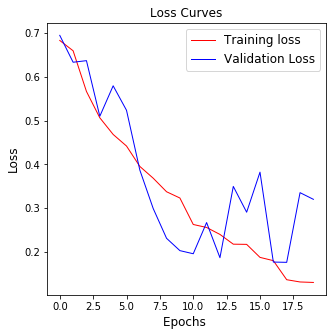

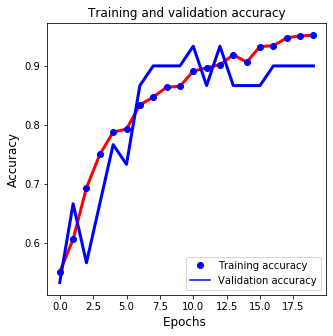

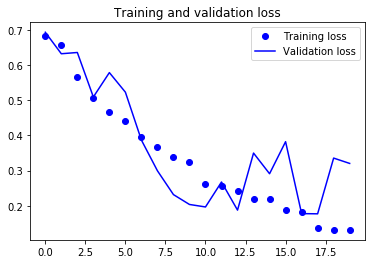

In [17]:
from keras.optimizers import SGD

sgd = SGD(lr=0.01,momentum=0.9)

sgd_model = model_fit(sgd,epochs)

### PREDICTION ON TEST DATA

In [18]:
#Predicting on test data

predictTestDataOnWindow(sgd_model)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


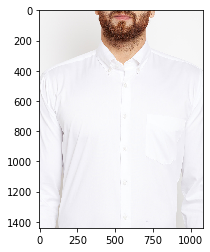

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


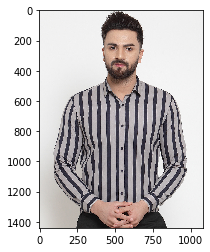

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


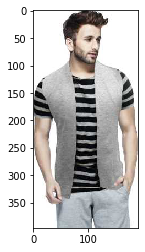

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


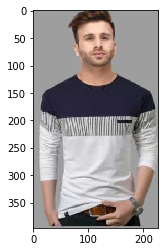

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


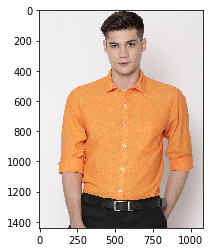

Predicted Label -  tshirts
True Label -  shirts
---------------------------------------------------------


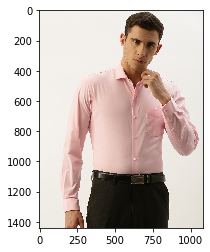

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


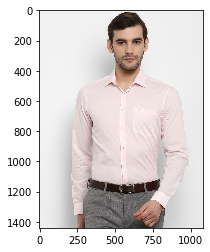

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


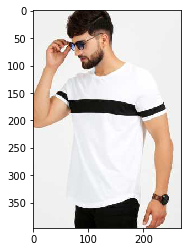

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


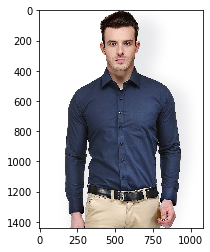

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


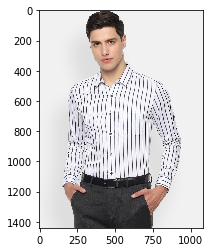

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


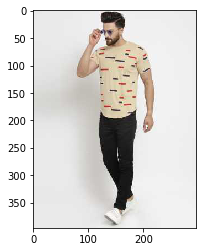

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


In [19]:
predictWithImages(sgd_model)

#### RMSprop

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 5.7967 - accuracy: 0.6584
Epoch 00001: val_loss did not improve from 0.17682
46/46 [==============================] - 13s 288ms/step - loss: 5.7967 - accuracy: 0.6584 - val_loss: 0.3037 - val_accuracy: 0.9000 - lr: 0.0100
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.5525 - accuracy: 0.7505
Epoch 00002: val_loss did not improve from 0.17682
46/46 [==============================] - 13s 279ms/step - loss: 0.5525 - accuracy: 0.7505 - val_loss: 1.2474 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.7937
Epoch 00003: val_loss did not improve from 0.17682
46/46 [==============================] - 12s 253ms/step - loss: 0.4991 - accuracy: 0.7937 - val_loss: 0.3826 - val_accuracy: 0.9000 - lr: 0.0100
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.8230
Epoch 00004: val_loss improved from 

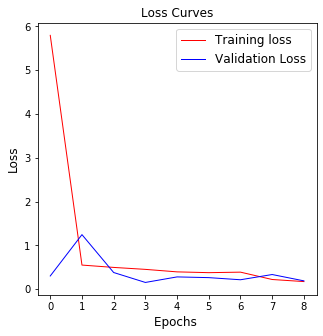

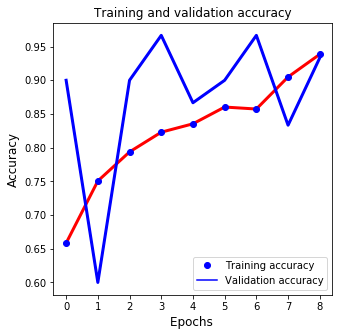

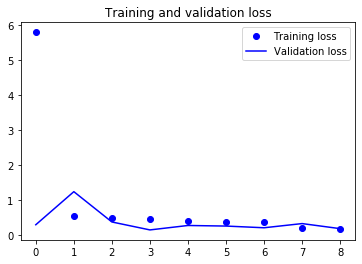

In [20]:
from keras.optimizers import RMSprop

rms = RMSprop(lr=0.01)

rms_model = model_fit(rms,epochs)

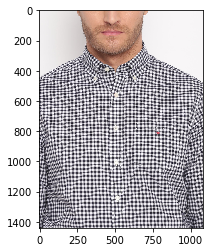

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


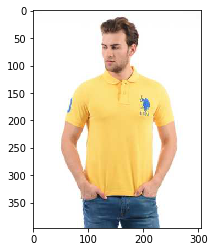

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


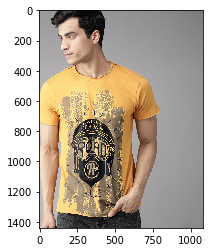

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


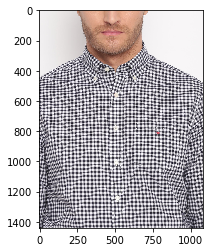

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


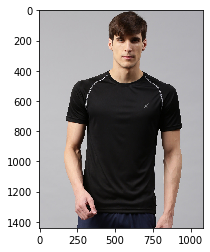

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


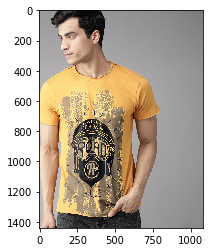

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


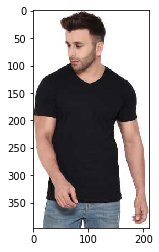

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


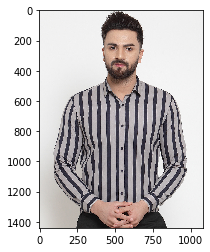

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


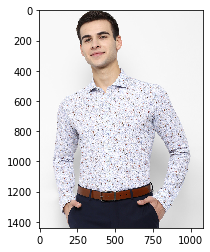

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


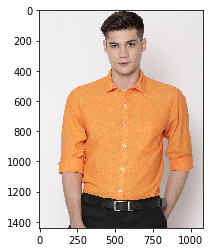

Predicted Label -  tshirts
True Label -  shirts
---------------------------------------------------------


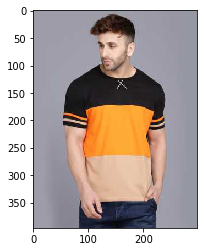

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


In [21]:
#Predicting on test data

predictWithImages(rms_model)

#### Adam Optimizer

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.8734
Epoch 00001: val_loss did not improve from 0.15592
46/46 [==============================] - 12s 253ms/step - loss: 0.4558 - accuracy: 0.8734 - val_loss: 0.2664 - val_accuracy: 0.8667 - lr: 0.0100
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8939
Epoch 00002: val_loss did not improve from 0.15592
46/46 [==============================] - 11s 247ms/step - loss: 0.2916 - accuracy: 0.8939 - val_loss: 0.3133 - val_accuracy: 0.8667 - lr: 0.0100
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.8976
Epoch 00003: val_loss did not improve from 0.15592
46/46 [==============================] - 12s 257ms/step - loss: 0.2492 - accuracy: 0.8976 - val_loss: 0.3289 - val_accuracy: 0.8333 - lr: 0.0100
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9144
Epoch 00004: val_loss did not improv

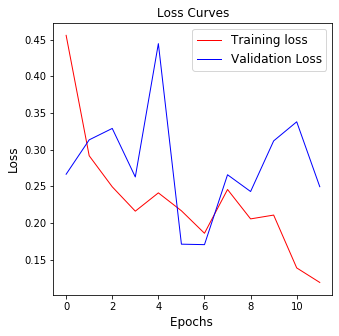

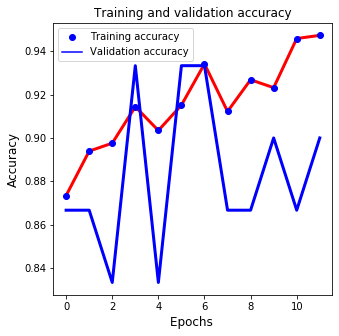

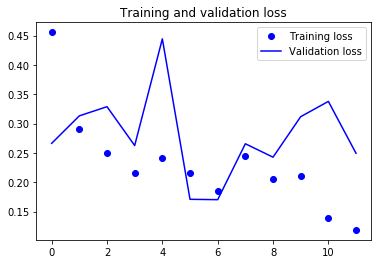

In [22]:
from keras.optimizers import Adam

adam = Adam(lr=0.01)
adam_model = model_fit(adam,epochs)

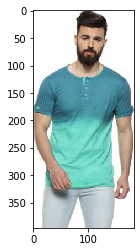

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


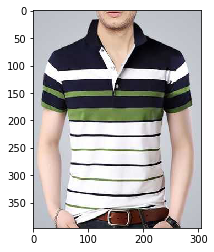

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


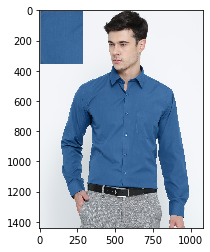

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


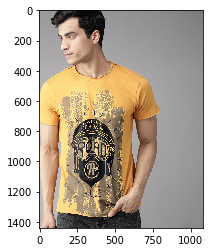

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


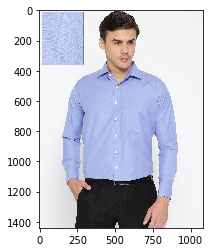

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


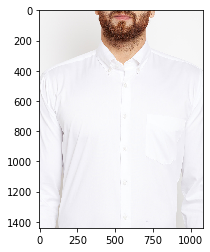

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


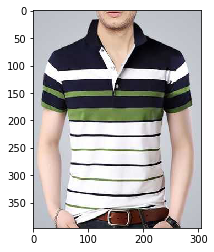

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


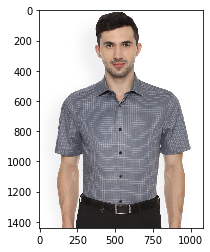

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


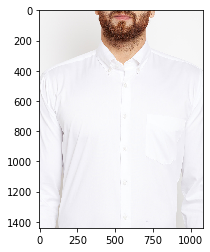

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


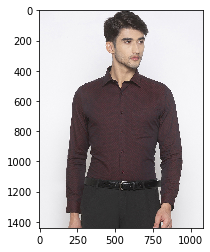

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


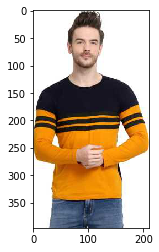

Predicted Label -  tshirts
True Label -  tshirts
---------------------------------------------------------


In [23]:
#Predicting on test data

predictWithImages(adam_model)

#### NADAM OPTIMISER

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 195.3427 - accuracy: 0.4982
Epoch 00001: val_loss did not improve from 0.15592
46/46 [==============================] - 12s 253ms/step - loss: 195.3427 - accuracy: 0.4982 - val_loss: 0.6913 - val_accuracy: 0.5333 - lr: 0.1000
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.5040
Epoch 00002: val_loss did not improve from 0.15592
46/46 [==============================] - 12s 257ms/step - loss: 0.6982 - accuracy: 0.5040 - val_loss: 0.6775 - val_accuracy: 0.6000 - lr: 0.1000
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.4850
Epoch 00003: val_loss did not improve from 0.15592
46/46 [==============================] - 12s 263ms/step - loss: 0.6979 - accuracy: 0.4850 - val_loss: 0.6884 - val_accuracy: 0.5667 - lr: 0.1000
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.4952
Epoch 00004: val_loss did not im

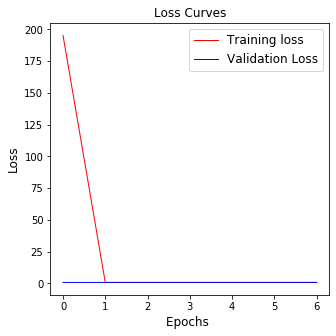

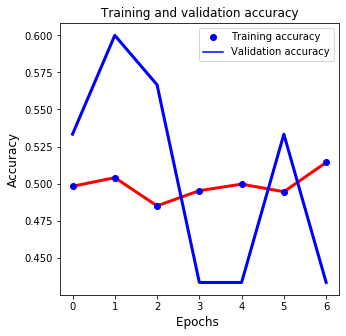

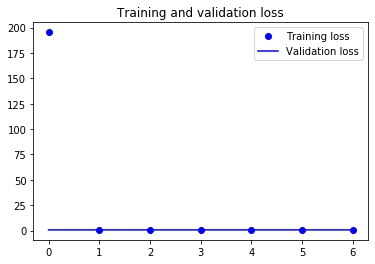

In [24]:
from keras.optimizers import Nadam

nadam = Nadam(lr=0.1)
nadam_model = model_fit(nadam,epochs)

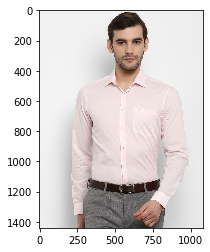

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


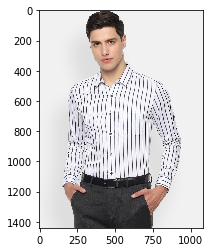

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


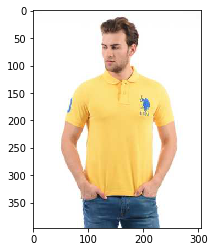

Predicted Label -  shirts
True Label -  tshirts
---------------------------------------------------------


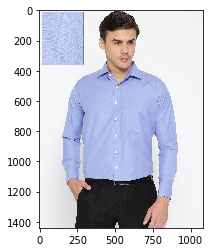

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


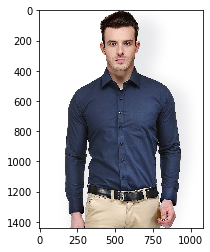

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


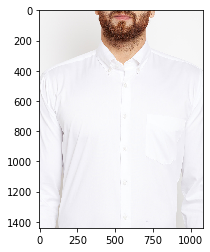

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


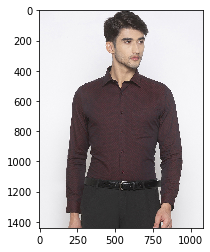

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


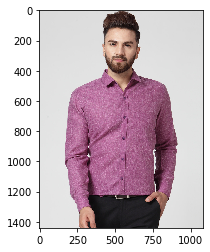

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


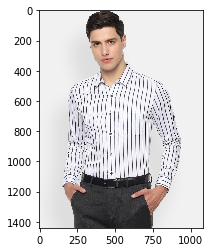

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


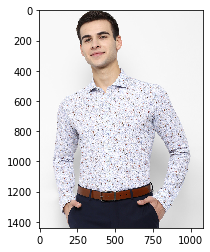

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


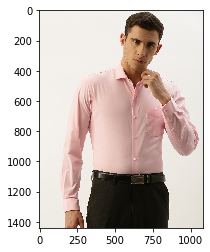

Predicted Label -  shirts
True Label -  shirts
---------------------------------------------------------


In [25]:
#Predicting on test data

predictWithImages(nadam_model)

### SAVING MODEL

In [26]:
#Saving the model
nadam_model.save('optimiser_and_callback_nadam.h5')

In [27]:
#Saving the model
adam_model.save('optimiser_and_callback_adam.h5')

In [28]:
#Saving the model
sgd_model.save('optimiser_and_callback_sgd.h5')

In [29]:
#Saving the model
rms_model.save('optimiser_and_callback_rmsprop.h5')

In [30]:
#loading the model for testing
from keras.models import load_model 
classifier = load_model('optimiser_and_callback_rmsprop.h5')

In [31]:
from keras.preprocessing import image
import numpy as np

#Loading image from drive
test_image =image.load_img('D:/DATASCIENCE/TshirtShirt/manual_test/17.jpg',target_size =(64,64))

#Converting image to array
test_image =image.img_to_array(test_image)
test_image =np.expand_dims(test_image, axis =0)

#Predicting image
result = classifier.predict(test_image)
if result[0][0] >= 0.5:
    prediction = 'tshirt'
else:
    prediction = 'shirt'
print(prediction)

tshirt


### CONCLUSION

In this assignment, I've tried to classify two category images. I downloaded images from Flipkart for two different categories by using a web scraping script. Then, saved all images in a directory with two labels as a t-shirt and shirt.Then imported the required libraries of Keras and created a model with a convolutional layers, a dense layer, and also added dropout to avoid overfitting/underfitting, then I've used various callbacks and optimisers to check model performance using learning rate and momentum for SGD, then compiled the model with test and train data, After testing multiple images manually I found that the model is predicting 8 out of 10 images correctly.